In this notebook, I explore fitting closed population capture-recapture models in PyMC. Capture-recapture, at least the Lincoln-Peterson estimator, has been around for almost 100 years. Since then, countless varieties of capture-recapture models have been developed for closed populations [@otis1978]. 

The basic steps in capture-recapture are: capture several individuals--e.g., via trapping--from the population of interest, mark these animals, then release them. We repeat this process several times, each time noting when we recapture individuals. 

| Individual  | $t_1$ | $t_2$ | $t_3$ | $t_4$ |
| ----------- | ----- | ----- | ----- | ----- |
| 001         | 1     | 1     | 0     | 1     |
| 002         | 0     | 1     | 1     | 1     |
| 003         | 0     | 0     | 1     | 1     |
: Example capture history, where $t$ is the sampling occasion and 1 indicates capture {#tbl-ch}

This produces a capture history for each individual, which allows us to estimate the probability of capture and the number of individuals in the population $N$.

# Model $M_0$

In [1]:
# libraries 
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt 
import seaborn as sns

plt.style.use('fivethirtyeight')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
# pal = sns.color_palette('Set2')
# sns.set_palette(pal)ß

# hyperparameters 
SEED = 808
RNG = np.random.default_rng(SEED)
DRAW_COUNT = 1000
M = 1500

I explore fitting the simplest closed capture-recapture model, Model $M_0,$ through parameter-expanded data-autmentation [PX-DA, @royle2008]. The idea with PX-DA is to augment the capture histories with $M-n$ all zero capture-histories, where $M$ is a hyperparameter that should be much greater than the true population size $N,$ and $n$ is the total number of individuals that were captured during the study. This allows us to treat the data as a zero-inflated binomial distribution (see below).

In [2]:
def augment_history(history):
    '''Augment a capture history with all-zero histories.'''
    
    animals_captured, T = history.shape

    # create M - n all zero histories
    zero_history_count = M - animals_captured
    zero_history = np.zeros((zero_history_count, T))

    # tack those on to the capture history
    augmented = np.row_stack((history, zero_history))

    return augmented 

To demonstrate this approach, I use the salamander dataset from @bailey2004, as demonstrated in @hooten2019, Chapter 24. These data were collected on two salamander species, the red-cheeked salamander (*Plethodon jordani*) and the pygmy salamander (*Desmognathus wrighti*), in Great Smoky Mountains National Park. The salamanders were counted in 15m by 15m square plots. In this case, we augment the history by setting $M=1500$ (see above). There were $n=92$ individual red-cheeked and $n=132$ pygmy salamanders captured during the course of the survey.

In [3]:
def get_history():
    '''Read, augment, and recombine the salamander histories.'''
    
    # read in salamander data 
    sal_data = pd.read_csv('sal_data.csv')
    
    # labels for capture history columns 
    col_labs = [f'y{t}' for t in range(1, 5)]

    # subset each dataset before augmenting 
    is_red = sal_data.spp == 0
    red = sal_data.loc[is_red, col_labs].to_numpy()
    
    is_pyg = sal_data.spp == 1
    pyg = sal_data.loc[is_pyg, col_labs].to_numpy()

    # augment each set separately since they differ in length
    red_augmented = augment_history(red)
    pyg_augmented = augment_history(pyg)

    # recombine into one history 
    history = np.concatenate((red_augmented, pyg_augmented))

    return history

history = get_history()
_, T = history.shape 

# summarize into binomial data
history_summarized = history.sum(axis=1)

For this model, I use the `pm.ZeroInflatedBinomial` class, just as I did in the [occupancy notebook](https://philpatton.github.io/occ.html). That said, the parameters here are different. First, $p$ represents the probability of capturing a given individual during the survey. Second, $\psi$ represents a mysterious entity known as the inclusion probability. That is, the probability that an individual from the hyportheitical superpopulation $M$ is included in the popualation of interest $N.$ Then, we can estimate the population size as $\hat{N}=M\hat{\psi},$ or generate posterior draws of $N,$ e.g., $N^{(s)} \sim \text{Bin}(M,\psi^{(s)})$

In this example, I combine the two species into one `pm.Model` object, making use of `coords`. That said, the parameters for each species are treated as independent. 

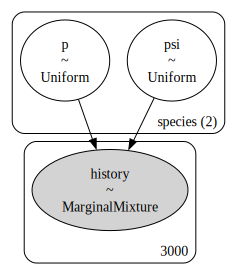

In [4]:
#| fig-cap: Visual representation of model $M_0.$ `MarginalMixture` refers to the zero-inflated binomial distribution.
#| label: fig-m0

# index for each species
species_idx = np.repeat([0, 1], M)

# coordinates identifying parameter each species  
coords = {'species': ['red_cheeked', 'pygmy']}

with pm.Model(coords=coords) as M0:

    # priors for the capture and inclusion probabilities
    psi = pm.Uniform('psi', 0, 1, dims='species')
    p = pm.Uniform('p', 0, 1, dims='species')

    # likelihood for the summarized data
    pm.ZeroInflatedBinomial(
        'history', 
        p=p[species_idx], 
        psi=psi[species_idx], 
        n=T,
        observed=history_summarized
    )
    
pm.model_to_graphviz(M0)

In [5]:
with M0:
    M0_idata = pm.sample(DRAW_COUNT)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [psi, p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 20 seconds.


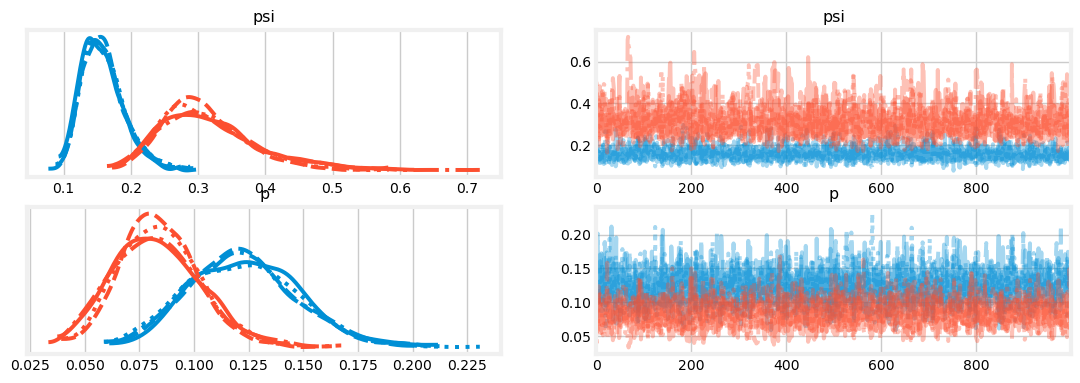

In [6]:
#| fig-cap: Traceplots for the salamander $M_0$ model. The red-cheeked salamander is in blue while the pygmy salamander is in red.
#| label: fig-trace

az.plot_trace(M0_idata);

For faster sampling, it's better to seperate the two species into two seperate models. On my machine, the individual species models finish sampling in 2-3 seconds, compared to 15-20 seconds for the two species model. That said, the two species model is somewhat more convenient.

Of course, the traceplots lack our true parameter of interest: the population size $N.$ We can simulate the posterior of $N$ as a *derived quantity*, using $M$ and the posterior distribuion of $\psi.$ Arviz has handy tools for calculating posteriors of derived quantities. 

In [7]:
# this does not make a copy of the posterior, allowing us to modify the idata object
post = M0_idata.posterior

# simulate draws of N 
N_samples = RNG.binomial(M, post.psi)

# add our draws back to the idata object, 
# specifying the dimensions of our array (species, chain, draw)
post['N'] = (post.dims, N_samples)

Now we can look at the traceplots, this time excluding $\psi$ and looking at $N.$ I also added the estimates from @hooten2019, Chapter 24, although they used a different prior for $\psi.$ 

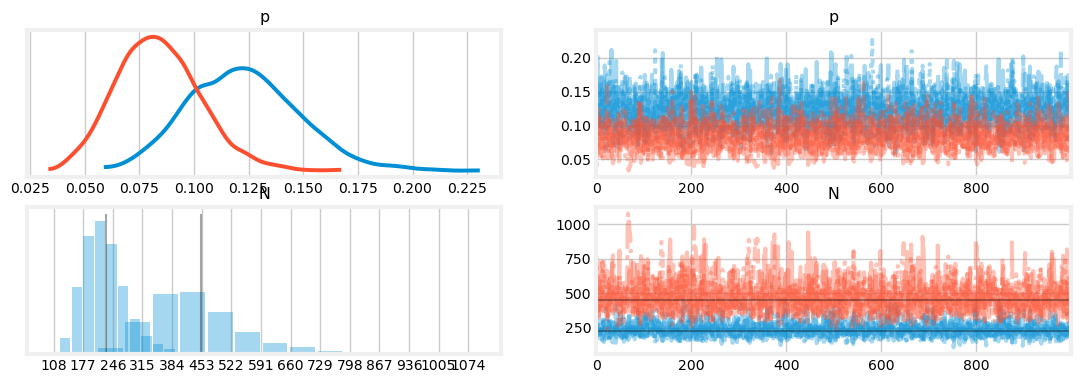

In [8]:
#| fig-cap: Traceplots for the salamander $M_0$ model, including $N$. Estimates from @hooten2019 are shown by the vertical lines
N_hooten = [229.6, 450.9]
az.plot_trace(M0_idata, var_names=['p', 'N'], combined=True,
              lines=[("N", {}, [N_hooten])]);

We might expect estimates of capture probability $p$ and the abundance $N,$ by way of the inclusion probability $\psi,$ to be somewhat correlated. We can explore this relationship visually by plotting the posterior draws. For a more custom look to the plots, I plot the draws using matplotlib

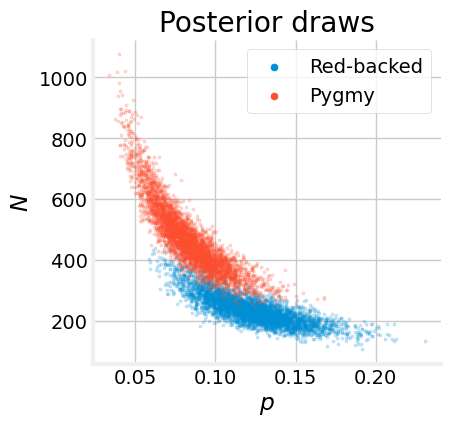

In [9]:
#| fig-cap: Posterior draws of $N$ and $p$ for both species of salamander.
#| fig-lab: post

# stack the draws for each chain, creating a (n_draws, n_species) array 
p_samps = np.vstack(post.p.to_numpy())
N_samps = np.vstack(post.N.to_numpy())

# create the plot
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

# add the scatter for each species
labs = ['Red-backed','Pygmy']
ax.scatter(p_samps[:,0], N_samps[:,0], s=5, alpha=0.2, label=labs[0])
ax.scatter(p_samps[:,1], N_samps[:,1], s=5, alpha=0.2, label=labs[1])

# this removes the opacity for the dots in the legend
leg = ax.legend()
for lh in leg.legend_handles: 
    lh.set(sizes=[25], alpha=[1])

# update aesthetics 
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

ax.set_ylabel(r'$N$')
ax.set_xlabel(r'$p$')
ax.set_title('Posterior draws')

plt.show()